# EDA Executive Summary

## Introduction

<div class="alert alert-block alert-info"> 
My objective with this project was to look at current location of wind turbines in the contiguous USA and see how that compares to mean wind speeds in the contiguous USA. I have a particular interest in renewable energy and wind turbines seem to get a bad rap all the time in the popular zeigeist for being ugly or rarely spinning. With this project I wanted to approximate if wind turbines were installed in appropriate places and see which areas of the US were optimal for turbine installation. <br>

Turbine technology has been improving quite rapdily over the past few decades so I had a hunch that older turbines might not be functioning optimally, but new ones might be better at maximizing their capacity.
<br>
        
I focused on metrics like turbine capacity, wind speed, and wind power in this project in order to allocate more time towards manipulating really large geo-datasets. I work with geo-data only briefly while doing my Master's in Public Health via ArcGIS, and I knew it would take some time for me to learn how to handle this type of data. 

</div>

## Data Explained

<div class="alert alert-block alert-info">
My first data source is from the Global Wind Atlas and contains wind speeds by georgraphic location at 50m above the ground. This data set was a large tif file that encompassed the contiguous USA plus Alaska, Hawaii, other outlying islands, and all the blank space in between. The challenge with "cleaning up" this data was actually just cropping the data down to a managable portion of the contiguous USA. The original data can be found here: https://globalwindatlas.info/api/gis/country/USA/wind-speed/50. One important feature of geodata is that it needs a Coordinate Reference System assigned to it in order to project the data correctly onto a 2D plane. This mean wind speed data is pulled from a larger data called ERA5 from the European Center for Medium Range Weather Forecasts that has a 30km grid spacing scale. The Global Wind Atlas team then using microscale modeling methods to apply a grid spacing of 3km and incorporate the effects of the terrain on mean windspeed. This data is comprehensive as possible for detailed views of geography. 
<br>    
    
My second data set is from the US Geological Survey Department and has locations and specifications for wind turbines in the US. You can link to it here:  https://eerscmap.usgs.gov/uswtdb/data/ To clean this data set I removed any rows where the data for turbine capacity or features related to the height and width of the turbines was missing, such as rotor diameter. There were a handful of rows for which I could input the height or width via geometric princples (per image below). I also removed a number of variables that were less pertinent to my objects such as project name or original equipment manufacturer.<br>
    
     
    
In order to see if the turbines were placed optimally I compared their manufactured capacity against the wind power of the area. In order to do this I had to join the two dataset together based on the proximity of the geographic coordinates; each wind speed is associated with a 3km squared area so I set parameters for the turbines to find the closest wind speed within 3km. This was very challenging because the rendering time was very long (more than 12 hours) but was achieved without duplicating any turbine data. 
<br>


    
Wind power is defined as [(density of air) * (rotor sweep area) * (wind speed)^3 ]/ 2 and the units are Watts/m. For this I needed to merge my two dataset together to get the mean windspeed withing a 3km^2 radius of the turbine.  For the purposes of this exploration I'm assuming that air density is uniform but that is definitely not the case in the real world. Air density changes based on temperature, elevation, seasonality, etc. Here we are calculating the wind power that passes over the turbine. Not all this wind power is actually captured by the turbine so from there I compared the wind power to the actual capacity of the turbine. I further labeled whether or not a turbine was within 10% of it's capacity, or above/below that range.     

</div>

Even though the data from the tif file (wind speed) was harder to manipulate, the data itself is quiet straight forward.

|Variable  | Description | Type |
| :------  | :-----    |  :---|
| X | x geographic coordinate | float 64|
| Y | y geographic coordinate |float 64|
| Z | mean wind speed in m/s |float 32|

The wind turbine data is extensive but I kept only the pertinent columns:


|Variable  | Category | Description | Type |
| :------     | :-----  | :-----    |  :---|
|case_id|id|unique uswtdb id|long|
|p_year	|project characteristic|	year project became operational	|int|
|p_cap	|project characteristic|	project capacity (MW)	|double|
|t_model|turbine characteristic|	turbine model	|str18|
|t_cap	|turbine characteristic|	turbine capacity (kW)	|int|
|t_cap_W	|created variable|	turbine capacity (W)	|int|
|t_hh	|turbine characteristic|	turbine hub height (meters)	|double|
|t_rd	|turbine characteristic|	turbine rotor diameter (meters)	|double|
|t_rsa	|turbine characteristic|	turbine rotor swept area (meters^2)	|double|
|t_ttlh	|turbine characteristic|	turbine total height - calculated (meters)	|double|
|xlong|	location|	longitude (decimal degrees - NAD 83 datum)	|double|
|ylat|	location|	latitude (decimal degrees - NAD 83 datum)	|double|
|geometry | geometry | x long and y lat as a single point | geometry|
|wind_power | created variable | amount of wind power passing over the turbine| int|
|cap_cat | created variable | whether the turbine is operating at, below, or above its designed capacity | str |



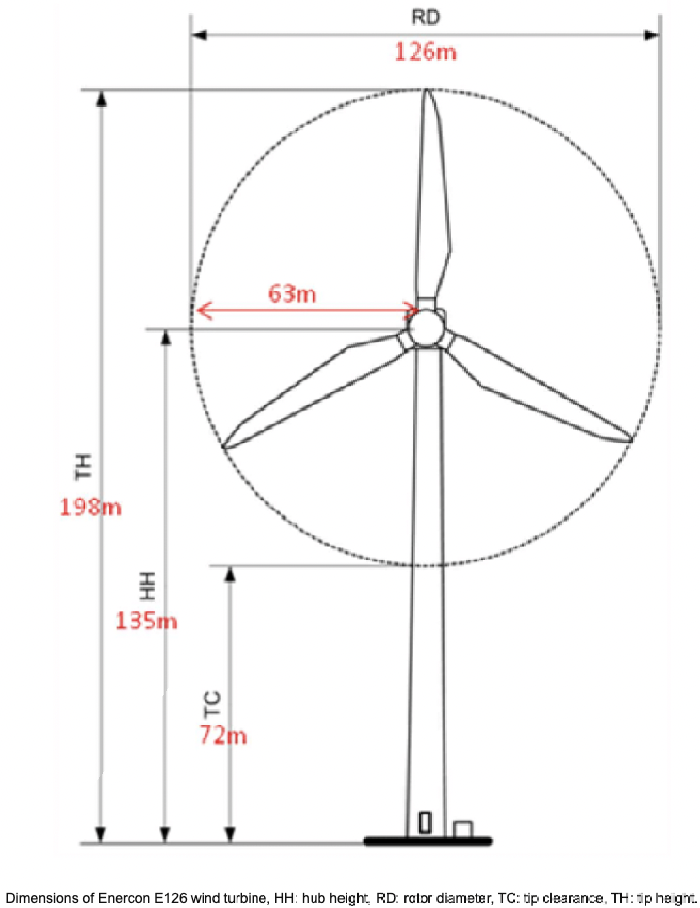

(from: https://www.researchgate.net/figure/Dimensions-of-Enercon-E126-wind-turbine-HH-hub-height-RD-rotor-diameter-TC-tip_fig2_255935013 )

For cleaning the turbine data I adhered to the following logical assumptions:
1. Any observations where the rotor diameter is greater than or equal to the height don't make sense
2. Any observations where total height is equalt to or greater than turbine height (t_hh) don't make sense
3. Any observations where the rotor sweep area is larger than the area of a circle as define by pi(r^2) where r is 1/2 rotor diameter don't make sense


## Results

<div class="alert alert-block alert-info">
This project required an extensive amount of packages. It was very important to create a separate environment for this project to get all these packages to cooperate.
</div>

In [17]:

import rioxarray as rxr
import rasterio as rs
import xarray
import pandas as pd
import numpy as np
# load for visuals
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# set up notebook to display multiple output in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import geopandas as gpd
import pyproj as pyproj
import os
from osgeo import gdal, osr
import georaster as gr

import rasterio as rio
from shapely.geometry import Point, Polygon
import pygeos 

import geoplot as gplt
import geoplot.crs as gcrs

%matplotlib inline
import geopandas as gpd
import geoplot as gplt

import georasters as grs
import matplotlib as mpl
import sys
import geoplot.crs as gcrs

In [16]:
input1 = pd.read_csv('/Users/antelope/Downloads/turbines_wind3.csv')

<div class="alert alert-block alert-info"> Going into this project, I had originally assumed that the total height of the turbine was the most important for turbine capacity but it turned out that rotor sweep area was most highly correlated. The equations for power generation reflects that as does the below correlation matrix. All dimensional characteristics are positiviely correlated with values over .6 which shows that all the dimensions are still important (this seems more of less obvious). 
     
</div>    

<AxesSubplot:>

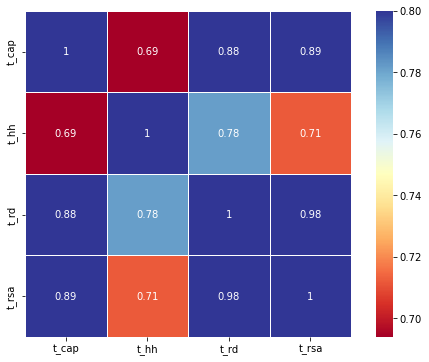

In [22]:
columns = input1.columns[4:8]
input_corr = input1[columns]

corr_matrix = input_corr.corr()

f, ax = plt.subplots(figsize=(9, 6))

sns.heatmap(corr_matrix, vmax=.8, square = True,  annot = True, cmap='RdYlBu', linewidths = .5)

<div class="alert alert-block alert-info"> Another aspect I was curious about was how much variability in capacity has is there for turbines. The technology has been getting better much faster recently so I'd suppose we'd see some newer high capacity turbines, but also hopefully lower capacity, older turbines are getting replaced. The below distribution hints that not all older/lower capacity turbines are being replaced. The minimum capacity is 50 KiloW where as the maximum is 6000 KiloW, which is a dramatic range.
     
</div> 

In [5]:
input1['t_cap'].describe().apply("{0:,.2f}".format)

count    66,676.00
mean      2,013.97
std         716.78
min          50.00
25%       1,600.00
50%       2,000.00
75%       2,300.00
max       6,000.00
Name: t_cap, dtype: object

<div class="alert alert-block alert-info"> Next I wanted to look at where these turbines are on a map. Is there a particular geographic pattern that we can deduce regarding capacity? Where generally are wind turbines located?</div> 

In [15]:
geometryt = gpd.points_from_xy(input1['xlong'], input1['ylat'])
turbines_geo = gpd.GeoDataFrame(input1, crs="epsg:3857", geometry=geometryt)
continental_usa_cities = gpd.read_file(gplt.datasets.get_path('usa_cities'))
continental_usa_cities = continental_usa_cities.query('STATE not in ["AK", "HI", "PR"]')
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

<GeoAxesSubplot:>

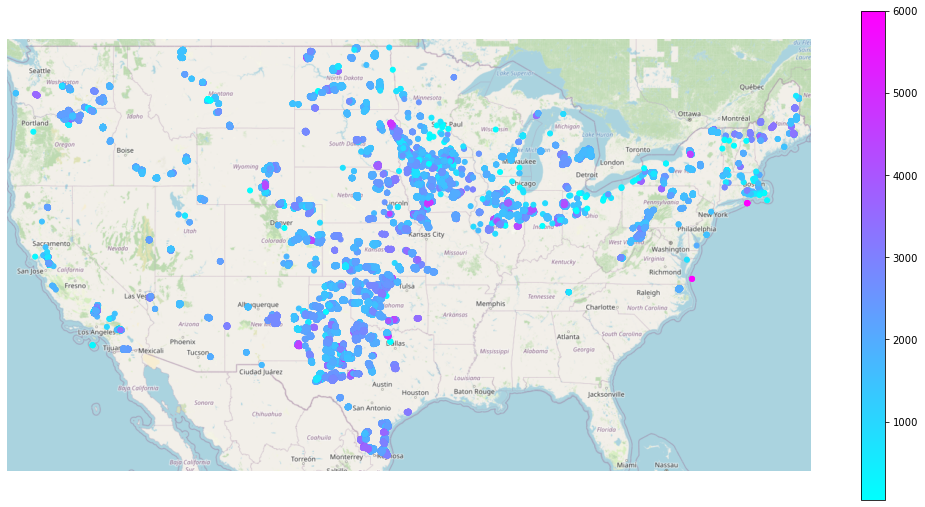

In [33]:
extent = contiguous_usa.total_bounds
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator(), figsize=(18, 9))
gplt.pointplot(turbines_geo, ax=ax, extent=extent, hue='t_cap', cmap='cool', legend=True)

The above map is showing us the capacity of wind turbines in kiloWatts. We can see based on the colors that most of the wind turbines in the US have a capacity of less than 3,000 kW. This aligns with our summary statistics above. Interestingly, the mix between higher and lower capacity turbines is relatively uniform in whatever areas have wind turbines, maybe with a trend towards lower capcity around the Great Lake Region and Boston. The exceptions seem to be on the coast. Off the coast of Virgina and New York there are a couple of very high capacity wind turbines. The wind turbine off the coast of Los Angeles is a particularly low capacity turbine.

<div class="alert alert-block alert-info"> Looking at the maps on Global Wind Atlas you could see the range of differences in wind speed but I wanted to see wind power quanitified as well. Wind is one of those forces that is hard to sense on a national scale. In my data preparation I calculated the wind power that passes over the turbine. Not all this wind power is actually captured by the turbine so after this we will compare the wind power to the actual capacity of the turbine. We can see from the summary statistics below that the wind powers span a very large interquartile range. The maximium wind power is almost 20 million W/m which is a very extreme outlier. </div> 

In [20]:
input1['wind_power'].describe().apply("{0:,.2f}".format)

count        66,676.00
mean      1,619,859.37
std         888,803.62
min             551.53
25%         984,225.75
50%       1,567,295.46
75%       2,123,275.79
max      19,358,282.67
Name: wind_power, dtype: object

<div class="alert alert-block alert-info">So what does the relationship between wind power and turbine capacity look like? Is there any consitent relationship when the turbines are man-made and their location is man-picked? Based on the scatterplot below it does look like there is a slight relationship, i.e. turbines are matched to some degree with areas that have wind power, but there are a lot of outliers here as well. </div> 

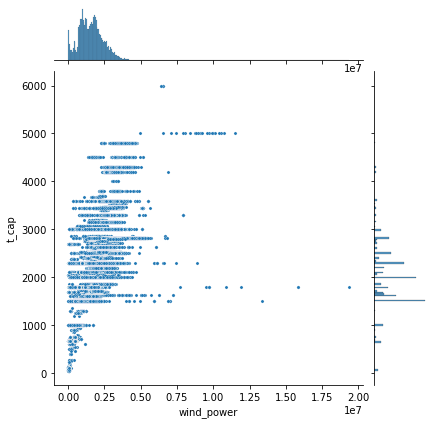

In [14]:
sns.jointplot(x='wind_power', y='t_cap', data=input1, joint_kws={"s":10});

<div class="alert alert-block alert-info"> Previously, I create a variable that compares the wind power against the turbines capacity. We shall consider turbines who's capacity are within 10% (either direction) of the wind power to be relatively equal, and we have other categories for capacity below that range and above it. <br>
The distribution of below shows us that 68.66% of turbines are functioning below their capacity. Said another way, we're not harnessing sufficient wind power given how the turbines have been placed (or operated) to date.     
</div> 

In [25]:
input1['cap_cat'].value_counts(normalize=True).apply("{:.2%}".format)

cap more          68.66%
cap within 10%    18.25%
cap less          13.09%
Name: cap_cat, dtype: object

<GeoAxesSubplot:>

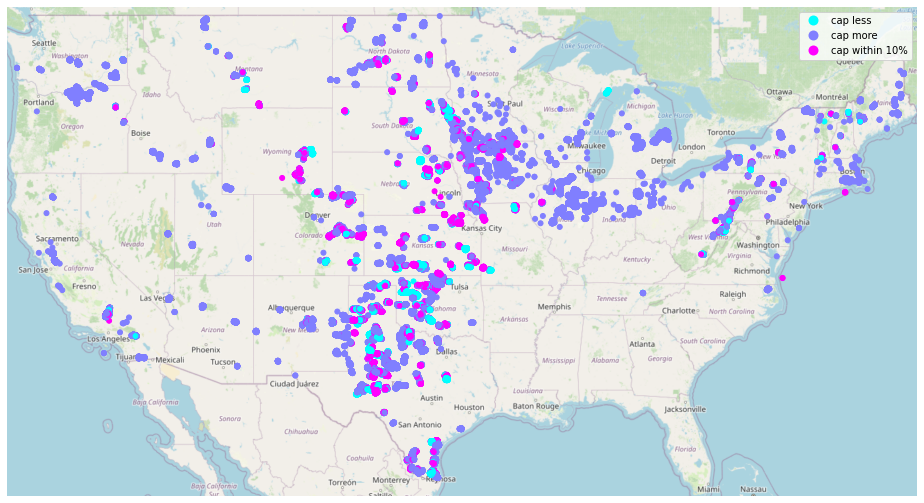

In [34]:
extent = contiguous_usa.total_bounds
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator(), figsize=(18, 9))
gplt.pointplot(turbines_geo, ax=ax, extent=extent, hue='cap_cat', cmap='cool', legend=True)


In the above map we can see that most wind turbines are installed in areas where the capacity of the wind turbine is more than the mean wind speed because we see the most purple dots. This isn't all together surprising given that mean wind speed is not telling us what the maximum gusts are for a region. Wind turbines will shut down when the wind gets too high or gusty to help preserve the internal mechanics. It could also be that the turbines installed in those locations where chosen to be placed there based on the average wind speed when there is any wind above X m/s, rather than the average from zero to infinite. The cyan dots tell us that there are a number of wind turbines who's capacity is less than the mean wind speed of the area. This might be an indication that the turbine model is not appropriate for the area or the turbine is aging out. The pink dots indicate those turbines who's capacity is within 10% of the mean windspeed. From what I understand of wind turbines this is the more ideal situation. Interesting, most of these turbines are located in the middle vertical strip of the US, but they are interclustered with many cyan and purple dots as well. I'd be interested to know if this mix might a result of experimentation with which turbines are best for the area at various wind farms or just different wind turbine operators determining model installation criteria in different ways. 

<div class="alert alert-block alert-info"> Next question that came to mind was whether or not there is a relationship between the year in which a turbine was installed and its capacity relative to wind power.  <br>
The below map tells us that most turbines have been installed after 2010, and that most of those installation have been in the middle of the country. The southeast US in noticable lacking in turbines. Comparing the two maps we see that turbines that match wind power more closely are associated with areas where newer installations have happened. 
</div> 

/Users/anastasia/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/geoplot/geoplot.py:56: UserWarning: The data being passed to "hue" includes null values. You probably want to remove these before plotting this data with geoplot.
  warnings.warn(


<GeoAxesSubplot:>

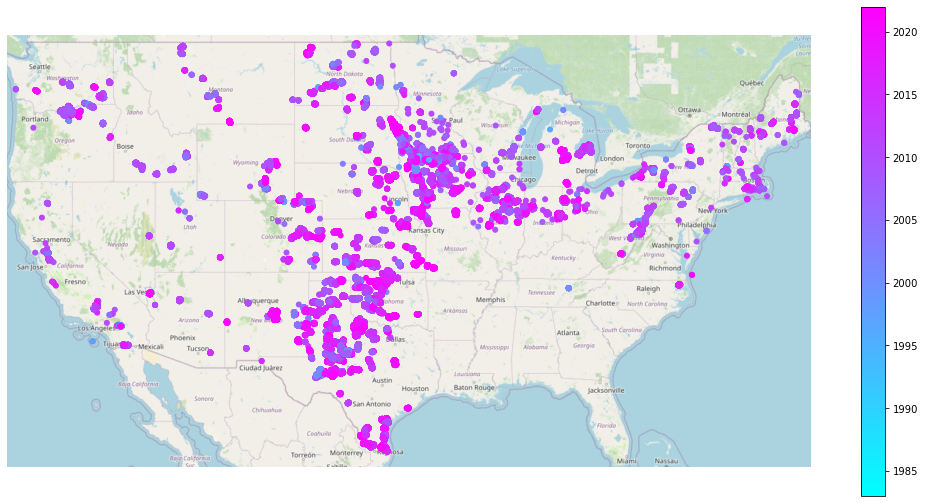

In [108]:
extent = contiguous_usa.total_bounds
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator(), figsize=(18, 9))
gplt.pointplot(turbines_geo, ax=ax, extent=extent, hue='p_year', cmap='cool', legend=True)


<div class="alert alert-block alert-info">From a technology standpoint I also just wanted to take a peak at how capacity was changing over time. Cool thing to see in the below table is that mean capacity is increasing quite steadily with time. The last year alone had an average improvement in capacity of more than 1000 KiloW. Improvements in technology pulling us forward!</div> 

In [109]:
#is capacity better if the turbines is newer?
turbines_geo[['p_year', 't_cap']].groupby('p_year').mean('t_cap')

t_cap
p_year             
1983.0    65.000000
1984.0    65.000000
1985.0    65.000000
1986.0   151.428571
1992.0   375.000000
1994.0   483.333333
1995.0   217.380952
1996.0   600.000000
1997.0   480.285714
1998.0   724.728261
1999.0   728.561525
2000.0   788.658537
2001.0   905.072626
2002.0   879.515284
2003.0  1403.121646
2004.0  1092.468354
2005.0  1530.903814
2006.0  1612.287390
2007.0  1652.919879
2008.0  1685.095896
2009.0  1741.289830
2010.0  1787.524786
2011.0  1977.935973
2012.0  1939.949753
2013.0  1861.410256
2014.0  1940.747798
2015.0  2004.635728
2016.0  2155.488304
2017.0  2110.569518
2018.0  2443.582262
2019.0  2550.634987
2020.0  2768.157513
2021.0  2954.859847
2022.0  4222.222222

<div class="alert alert-block alert-info">Lastly, we should compare the wind speeds across the contiguous US and where turbines are placed. This map is generated from raster data and the more green the area the faster the wind. (The legend is weirdly normalized to show range I couldn't quite figure out how to reset it to reflect actual speeds.)<br>

We can deduce that the highest wind speed exist across the plains of the middle reagion of the country. This coincides nicely with where turbines are installed. Offshore wind is also particularly strong, which validates the newer offshore wind installations prominently mentioned in the news. The Appalachia range and the Rocky Mountains do not seem to be ideally suited for wind turbines with their lower wind speeds. Mountains also have up/down draft affects which based on the literature, are not good for the longevity of turbines and their functionality.<br>

Based on the location of where wind turbines are located, and what the capacity of a given turbine is relatively to the surrounding windspeed, I think it's safe to deduce the US could install more turbines and experiment through figuring out which turbines are best for which area. With the recent Inflation Reduction Act, hopefully we'll see even more installations!



<Figure size 2160x504 with 0 Axes>

([], [])

([], [])

Text(0.5, 1.0, '')

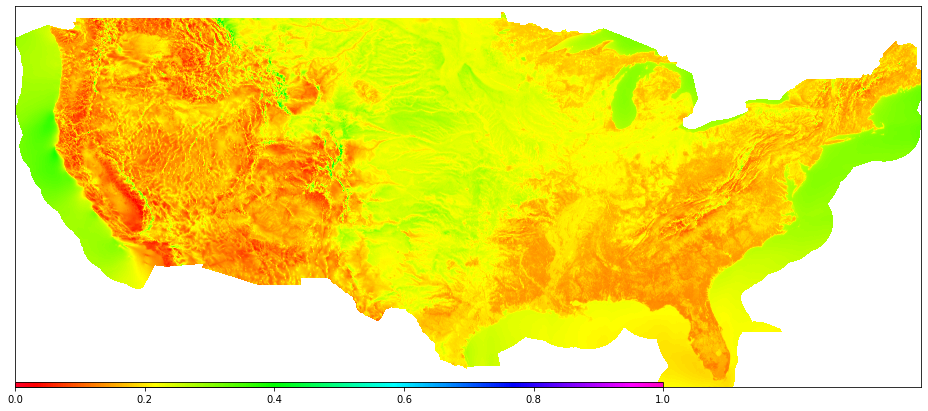

In [21]:
ds = gdal.Open(r"/Users/antelope/Downloads/new_one.tif")
data = ds.GetRasterBand(1).ReadAsArray()
#plt.imshow(data)
plt.figure(figsize = (30,7))
#plt.imshow(data, cmap='Paired')
plt.imshow(data, cmap='gist_rainbow')
plt.xticks([])
plt.yticks([])
plt.title('')
ax = plt.gca()
pos = ax.get_position() 
l, b, w, h = pos.bounds 
cax = plt.axes([l, b, .3, 0.01]) 
# draw colorbar on bottom. 
cb = mpl.colorbar.ColorbarBase(cax, cmap='gist_rainbow', spacing='proportional', orientation='horizontal')

## Summary

<div class="alert alert-block alert-info"> 
    
In summary, we have quite a few turbines in the contigous US that are spread across most of the country (except the SE) that have varying degrees of capacity and varying degrees of "fit" for their placement. Newer turbines placed in the middle of the country seem to fit better vis a vis capacity and local wind speed. The capacity of turbines is also increasing steadily in recent years to capture more energy.<br>
    
We can conclude from this that the US has the potential to continue capturing a lot of wind power for energy. The middle of the US sees the highest mean wind speeds as well as off the coasts, so setting up more wind farms in those areas would be beneficial for the clean energy transition. Even the Great Lakes offer more potential energy. Additinally, the turbines installed are getting better at generating power. <br>
    
The greatest difficulties with this project was getting the data to a manageble size. The wind data is immense and it has geoinformation as well. The second challenge was learning how to properly install packages in an environment dedicated to this project specifically. Installing packages to the base environment messed with all python functionality and the individual packages interfered with one another. <br>
    
    
A difficulty I'm still facing is for rendering a map based on the wind data with the turbine data overlaid on top. Folium would have produced a very sophisticated looking map, but my local installation of Jupyter could not handle passing folium such a large string of wind data. The map above for wind speed is based on raster data and I have not yet figured out how to layer raster data with geo points. <br>
    
    
An additional next step would include refining the calculation of wind power. I assumed a particular air density, but I can also merge that data into the existing data for more accurate calculations. I also would like to refine the relationship between wind power and turbine energy output, given sustained wind speeds for a particular time frame. Alas, I did not have time to research more of the physics and engineering of that for this project. 
    

</div>